In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import os
import tensorflow as tf
print(os.getcwd())


data_path = os.path.join(os.getcwd(), 'data')
X = np.load(os.path.join(data_path, 'X_70_500.npy'), allow_pickle=True)
Y = np.load(os.path.join(data_path, 'Y_70_500.npy'), allow_pickle=True)
testidx = 10
noised_clip = X[testidx]
clean_clip = Y[testidx]
noise_clip = noised_clip - clean_clip

freq_bins = X[0].shape[0]
min_spec_len = min([x.shape[1] for x in X])
# min_spec_len = 300
data_size = X.shape[0]
# X = np.reshape(X, newshape=(data_size, nfft_bins,None ))
print(data_size, freq_bins, min_spec_len)
# for i in range(data_size):
    # x,y = X[i] , np.copy(Y[i])
    # X[i], Y[i] = x.resize((freq_bins, min_spec_len)), y.resize((freq_bins, min_spec_len))
X = [tf.stack(x[:,:min_spec_len]) for x in X]


# Y = [X[i] - tf.stack(y[:,:min_spec_len])  for i,y in enumerate(Y)]
Y = [tf.stack(abs(y)[:,:min_spec_len])  for i,y in enumerate(Y)]

splits = train_test_split(X, Y, test_size=0.3, random_state=69)
X_train, X_test, y_train, y_test = [tf.convert_to_tensor(s) for s in splits]
for item in [X_train, X_test, y_train, y_test]:
    print(item.shape, item.dtype, type(item))



c:\Users\Julio\Documents\Projects\audio-denoiser
500 513 122
(350, 513, 122) <dtype: 'complex64'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 513, 122) <dtype: 'complex64'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(350, 513, 122) <dtype: 'float32'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(150, 513, 122) <dtype: 'float32'> <class 'tensorflow.python.framework.ops.EagerTensor'>


In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalizationV2, GlobalMaxPooling2D
from keras.layers import Flatten, Dropout, AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import adam_v2
from keras import layers
import keras

# import rms prop from keras
# A Keras tensor is a symbolic tensor-like object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
opt = adam_v2.Adam(learning_rate=0.0007)

# inputs are 2d arrays of shape [nfft_bins, time], time is a varied
lookahead = 4
frequency_bins = freq_bins
data_shape = (frequency_bins, min_spec_len)
model_input = layers.Input(shape=(frequency_bins, min_spec_len), dtype=np.complex64)
# add channel dimension
x_imag = tf.math.imag(model_input)
# print(x_imag.shape)
x = tf.abs(model_input)
x = model_input
x = tf.expand_dims(x, axis=-1)
x = layers.BatchNormalization(axis=[1])(x)

# frequency_bins//32,lookahead
x = layers.Conv2D(filters=16, kernel_size=(2,5),  padding='same', activation=keras.activations.leaky_relu)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=32, kernel_size=(4,7), padding='same', activation=keras.activations.leaky_relu)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=16, kernel_size=(6,9),  padding='same', activation=keras.activations.leaky_relu)(x)
x = layers.Dropout(0.2)(x)

# x = layers.Conv2D(filters=4, kernel_size=(frequency_bins//16,1),  padding='same', activation='relu')(x)
# x = layers.Dropout(0.2)(x)

x = layers.BatchNormalization(axis=[1])(x)
x = layers.Conv2D(filters=1, kernel_size=(1,1),  padding='same', activation='tanh')(x)

x = tf.squeeze(x, axis=-1)
out = tf.complex(x, x_imag)
# out = x
model = keras.Model(inputs=model_input, outputs=out)
model.summary()
model.compile(loss=keras.losses.Huber(), optimizer='adam', metrics=['mae'])

# model.add(GlobalMaxPooling2D())
# model.add(Flatten())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 513, 122)]        0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 513, 122, 1)      0         
 a)                                                              
                                                                 
 batch_normalization_2 (Batc  (None, 513, 122, 1)      2052      
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 513, 122, 16)      176       
                                                                 
 dropout_3 (Dropout)         (None, 513, 122, 16)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 513, 122, 32)      1436

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
/device:GPU:0
Epoch 1/50
9/9 [==============================] - 6s 693ms/step - loss: 0.1253 - mae: 0.2114 - val_loss: 0.1188 - val_mae: 0.1841
Epoch 2/50
9/9 [==============================] - 6s 729ms/step - loss: 0.1246 - mae: 0.2101 - val_loss: 0.1189 - val_mae: 0.1839
Epoch 3/50
9/9 [==============================] - 7s 730ms/step - loss: 0.1241 - mae: 0.2093 - val_loss: 0.1182 - val_mae: 0.1840
Epoch 4/50
9/9 [==============================] - 6s 673ms/step - loss: 0.1234 - mae: 0.2086 - val_loss: 0.1185 - val_mae: 0.1837
Epoch 5/50
9/9 [==============================] - 6s 688ms/step - loss: 0.1229 - mae: 0.2067 - val_loss: 0.1171 - val_mae: 0.1842
Epoch 6/50
9/9 [==============================] - 7s 735ms/step - loss: 0.1223 - mae: 0.2056 - val_loss: 0.1173 - val_mae: 0.1839
Epoch 7/50
9/9 [==============================] - 7s 738ms/step - loss: 0.1218 - mae: 0.2052 - val_loss: 0.1171 - val_mae: 0.1837
Epoc

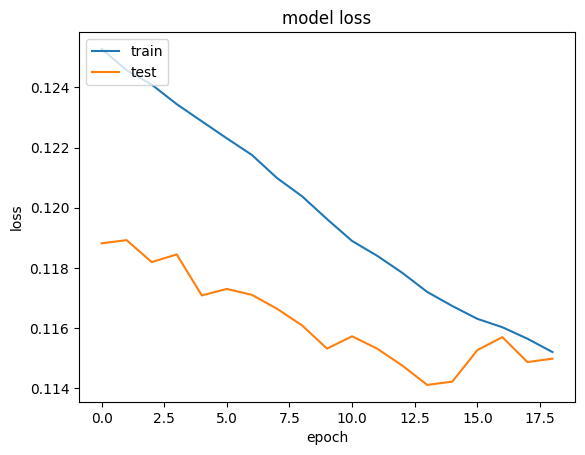

In [8]:
tf.debugging.set_log_device_placement(True)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())
# print(tf.test.is_gpu_available(cuda_only=True, min_cuda_compute_capability=None))
cnnhistory=model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=40, callbacks=[es],epochs=50, verbose=1)
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plt.subplot(1, 2, 2)
# plt.plot(cnnhistory.history['accuracy'])
# plt.plot(cnnhistory.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


In [ ]:
import librosa
import librosa.display

test_sample = X_test[testidx]
true_sample = y_test[testidx]
print(test_sample.shape)
test_Result = model.predict(tf.expand_dims(test_sample, axis=0))
np.squeeze(test_Result)
# test_Result.shape
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Noisy Speech Segment')
librosa.display.specshow(librosa.amplitude_to_db(abs(np.squeeze(test_sample)), ref=np.max), y_axis='log', x_axis='time')
plt.subplot(1, 3, 2)
plt.title('Estimated Clean Speech')
librosa.display.specshow(librosa.amplitude_to_db(abs(np.squeeze(test_Result)), ref=np.max), y_axis='log', x_axis='time')
plt.subplot(1, 3, 3)
plt.title('True Clean Speech')
librosa.display.specshow(librosa.amplitude_to_db(abs(np.squeeze(true_sample)), ref=np.max), y_axis='log', x_axis='time')


In [ ]:
# librosa.istft(np.squeeze(test_Result))
import IPython.display as ipd
ipd.Audio(librosa.istft(test_Result, n_fft= 1024, hop_length=int(1024/2)), rate=44100)